### 1 . Khởi tạo Spark Session & nạp dữ liệu

#### 1.1. Xem schema


In [353]:
# 1. Khởi tạo SparkSession
import os
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TaxiDuration").getOrCreate()

DATA_PATH = "/home/jovyan/work/data/raw/train.csv"

# 2. Đọc dữ liệu
df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)
# 3. Kiểm tra nhanh
print("Số dòng dữ liệu:", df.count())
df.printSchema()
df.show(20, truncate=False)



Số dòng dữ liệu: 1458644
root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id       |vendor_id|pickup_datetime    |dropoff_datetime   |passenger_count|pickup_longitude  |pickup_latitude   |dropoff_longitude |dropoff_latitude  |store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-----

Dữ liệu gồm 
- 1 458 644 dòng
- schema 11 cột: (nullable -> cần kiểm tra missing/null)

overview các cột:
- định danh:
    - `id` (string): ID định danh cho chuyến đi (Không có giá trị mô hình hoá)
    - `store_and_fwd_flag` (sring): store and forward flag cho biết liệu thông tin chuyến đi có bị mất kết nối với máy chủ tạm thời hay không.
        - 'N' (No): Chuyến đi được gửi về máy chủ ngay lập tức (kết nối mạng tốt). Đây là trường hợp phổ biến nhất.
        - 'Y' (Yes): Do mất kết nối, dữ liệu chuyến đi được lưu tạm thời vào bộ nhớ của thiết bị trên xe và chỉ được gửi đi sau khi có kết nối trở lại. -> có thể sai lệch thời gian pickup và dropoff nhưng không rõ ràng.
    - `vendor_id` (string): id định dang cho nhà cung cấp, có thể ảnh hưởng từ sở thích của khách hàng
- thời gian:
    - `pickup_datetime` (timestamp): thời điểm bắt đầu, **important** -> có thể trích xuất đặc trưng (pickup_hour, day_of_week, is_weekend, month, is_rush_hour,...)
    - `dropoff_datetime` (timestamp): thời điểm trả khách, **remove leakage** -> yếu tố tương lai làm lộ kết quả trip_duration.
- hành khách:
    - `passenger_count` (integer): số lượng khách trên xe, **numeric feature**, cần loại bỏ 0
- Toạ độ:
    - `pickup_longtitude`, `pickup_latitude` (double): Toạ độ đón khách
    - `dropoff_longtitude`, `dropoff_latitude` (double): Toạ độ trả khách
-> Tính khoảng cách (chọn Haversine), có thể kết hợp với clustering địa lý (để cho hướng phát triển thêm sau này)
-> sinh cột distance
- Cột đích:
    - `trip_duration` (int): thời gian di chuyển, **target var**, đơn vị: second

#### 1.2. Mô tả dữ liệu

In [354]:
# 1.2. Mô tả dữ liệu
print("=== THỐNG KÊ MÔ TẢ CƠ BẢN ===")
df.describe().show()

print("\n=== THỐNG KÊ CHI TIẾT TỪNG CỘT ===")
# Thống kê các cột số
numeric_cols = ["passenger_count", "pickup_longitude", "pickup_latitude", 
                "dropoff_longitude", "dropoff_latitude", "trip_duration"]

for col in numeric_cols:
    print(f"\n{col}:")
    df.select(col).describe().show()

print("\n=== THỐNG KÊ CÁC CỘT CATEGORICAL ===")
# Thống kê các cột categorical
categorical_cols = ["vendor_id", "store_and_fwd_flag"]

for col in categorical_cols:
    print(f"\n{col}:")
    df.groupBy(col).count().orderBy(col).show()

=== THỐNG KÊ MÔ TẢ CƠ BẢN ===
+-------+---------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+
|summary|       id|         vendor_id|   passenger_count|   pickup_longitude|    pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|    trip_duration|
+-------+---------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+
|  count|  1458644|           1458644|           1458644|            1458644|            1458644|            1458644|           1458644|           1458644|          1458644|
|   mean|     NULL|1.5349502688798637|1.6645295219395548| -73.97348630489282| 40.750920908391734|  -73.9734159469458|  40.7517995149002|              NULL|959.4922729603659|
| stddev|     NULL|0.4987771539073999| 1.314242167823114|0.07090185842270268|0.03288118625763357|0.0

### 2. Kiểm tra null values

In [355]:
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, FloatType
def quick_null_check(df_):
    # check null or NaN (for double/float)
    return df_.select([
        F.count(F.when(F.col(c).isNull() | 
                      (F.isnan(c) if isinstance(df_.schema[c].dataType, (DoubleType, FloatType)) 
                       else F.lit(False)), 1)).alias(c)
        for c in df_.columns
    ])

null_counts = quick_null_check(df)
null_counts.show()

+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
| id|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|  0|        0|              0|               0|              0|               0|              0|                0|               0|                 0|            0|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+



Không có giá trị null

### 3. Phân phối dữ liệu


In [356]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
CHART_DIR = "/home/jovyan/work/docs/charts/"
os.makedirs(CHART_DIR, exist_ok=True)

#### 3.1. Mô tả `store_and_fwd_flag`

In [357]:
# Đếm tần suất 'N' và 'Y'
df.groupBy("store_and_fwd_flag").count().orderBy("store_and_fwd_flag").show()

+------------------+-------+
|store_and_fwd_flag|  count|
+------------------+-------+
|                 N|1450599|
|                 Y|   8045|
+------------------+-------+



Dù giá trị 'Y' chỉ chiếm rất nhỏ (0.55%) song vẫn có những tác động thiết thực tới kết quả dự đoán.
THực hiện mã hoá nhị phân: 'N' = 0, 'Y'= 1

In [358]:
# tạo cột store_and_fwd_flag_num mã hoá nhị phân: 'N' = 0, 'Y'= 1
df = df.withColumn("store_and_fwd_flag_num", (F.col("store_and_fwd_flag") == "Y").cast("int"))
df.groupBy("store_and_fwd_flag_num").count().orderBy("store_and_fwd_flag_num").show()
# Trong 02-Feature-Engineering-and-Modeling.ipynb sẽ thay
#   cột thủ công này bằng StringIndexer trong Pipeline.


+----------------------+-------+
|store_and_fwd_flag_num|  count|
+----------------------+-------+
|                     0|1450599|
|                     1|   8045|
+----------------------+-------+



#### 3.2. Mô tả `vendor_id`

+---------+------+
|vendor_id| count|
+---------+------+
|        1|678342|
|        2|780302|
+---------+------+



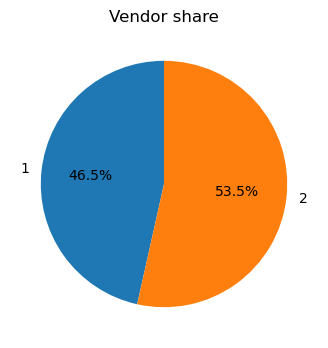

In [359]:
# Biểu đồ phân phối số lượng taxi theo vendor_id (pie chart)
vi_df = df.groupBy("vendor_id").count().orderBy("vendor_id")
vi_df.show()

# Pie chart nhỏ
plt.figure(figsize=(4,4))
plt.pie(vi_df.toPandas()["count"],
        labels=vi_df.toPandas()["vendor_id"],
        autopct="%1.1f%%", startangle=90)
plt.title("Vendor share")
plt.savefig(CHART_DIR + "vendor_distribution_pie.png", 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


vender_id có 2 giá trị, là 2 hãng dịch vụ. Tỷ lệ khá cân, tức yếu tố sở thích lựa chọn hãng của khách hàng không ảnh hưởng nhiều tới dữ liệu.

Song, vender_id có thể vẫn ảnh hưởng tới trip_duration bởi chất lượng dịch vụ mà hãng cung cấp

+---------+------------------+
|vendor_id|      avg_duration|
+---------+------------------+
|        1| 845.4382435408687|
|        2|1058.6431638006823|
+---------+------------------+



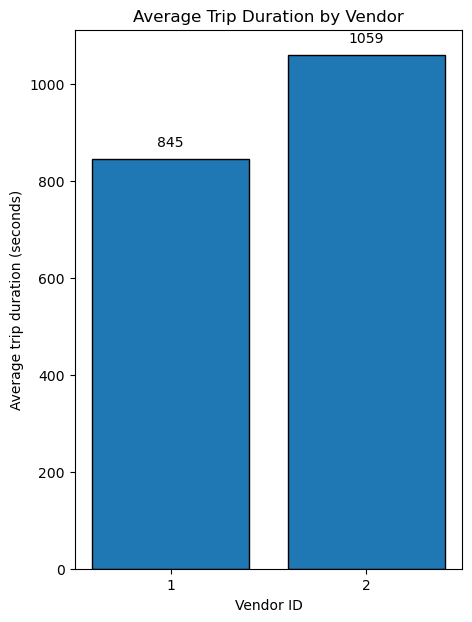

In [360]:

# Biểu đồ phân phối trung bình trip_duration theo vendor_id (bar chart)
avg_df = (df.groupBy("vendor_id")
            .agg(F.avg("trip_duration").alias("avg_duration"))
            .orderBy("vendor_id"))
avg_df.show()

pdf = avg_df.toPandas()

plt.figure(figsize=(5,7))
plt.bar(pdf["vendor_id"].astype(str), pdf["avg_duration"], edgecolor="black")
plt.xlabel("Vendor ID")
plt.ylabel("Average trip duration (seconds)")
plt.title("Average Trip Duration by Vendor")

# Thêm nhãn số lên mỗi cột
for idx, val in enumerate(pdf["avg_duration"]):
    plt.text(idx, val + 20, f"{val:.0f}", ha="center", va="bottom")
plt.savefig(CHART_DIR + "vendor_avg_duration_bar.png", 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


Nếu chuyến đi thuộc về Vendor 2, thời gian chuyến đi có thể sẽ dài hơn một chút so với Vendor 1, khi các yếu tố khác là như nhau.

#### 3.3. Mô tả `passenger_count`

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              0|     60|
|              1|1033540|
|              2| 210318|
|              3|  59896|
|              4|  28404|
|              5|  78088|
|              6|  48333|
|              7|      3|
|              8|      1|
|              9|      1|
+---------------+-------+



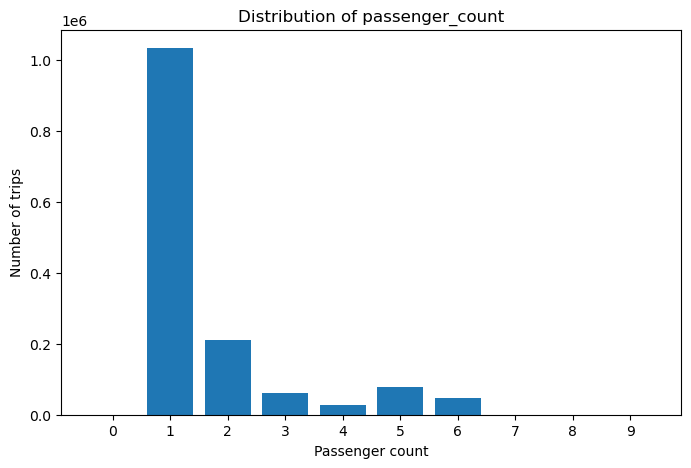

In [361]:
# Bảng tần suất số lượng hành khách
pc_df = df.groupBy("passenger_count").count().orderBy("passenger_count")
pc_df.show()

# Bar chart
counts = pc_df.toPandas()
plt.figure(figsize=(8,5))
plt.bar(counts["passenger_count"], counts["count"])
plt.xlabel("Passenger count")
plt.ylabel("Number of trips")
plt.title("Distribution of passenger_count")
plt.xticks(counts["passenger_count"])

plt.savefig(CHART_DIR + "passenger_count_distribution.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

**Loại bỏ** các outlier có passenger_count = {0, 7, 8, 9} do số lượng quá nhỏ

In [362]:
print(f"Số dòng trước lọc passenger_count outliers : {df.count()}")
# Lọc passenger_count not in [0, 7, 8, 9]
df = df.filter(~F.col("passenger_count").isin([0, 7, 8, 9]))
print(f"Số dòng sau  lọc passenger_count outliers : {df.count()}")
(df.groupBy("passenger_count")
   .count()
   .orderBy("passenger_count")
   .show())

Số dòng trước lọc passenger_count outliers : 1458644
Số dòng sau  lọc passenger_count outliers : 1458579
+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              1|1033540|
|              2| 210318|
|              3|  59896|
|              4|  28404|
|              5|  78088|
|              6|  48333|
+---------------+-------+



#### 3.4. Phân tích toạ độ pickup và dropoff

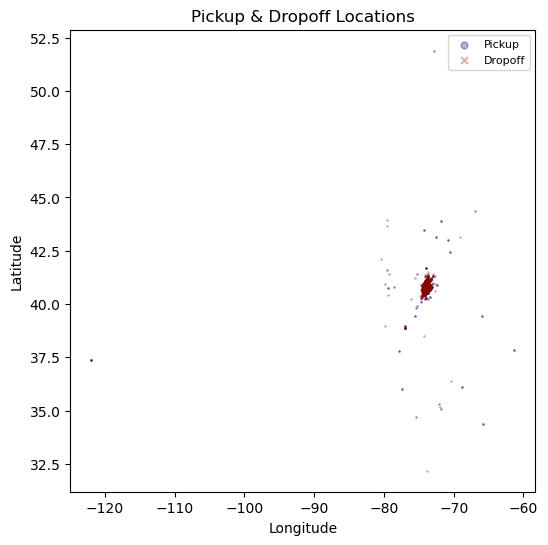

In [363]:
coords_pdf = df.select(
    F.col("pickup_longitude").alias("lon"),
    F.col("pickup_latitude").alias("lat"),
    F.col("dropoff_longitude").alias("lon2"),
    F.col("dropoff_latitude").alias("lat2")
).toPandas()


# scatter với tọa độ pickup và dropoff
plt.figure(figsize=(6,6))
plt.scatter(coords_pdf["lon"], coords_pdf["lat"],
            s=1, alpha=0.3, label="Pickup", color="navy", marker="o")
plt.scatter(coords_pdf["lon2"], coords_pdf["lat2"],
            s=1, alpha=0.3, label="Dropoff", color="darkred", marker="x")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Pickup & Dropoff Locations")
plt.legend(markerscale=5, fontsize=8)

plt.savefig(CHART_DIR + "pickup_dropoff_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

Biểu đồ cho thấy
- Khu vực hoạt động chính: Có một cụm điểm màu xanh và đỏ rất dày đặc tập trung quanh kinh độ -74 và vĩ độ 40. Chủ yếu tập trung ở đảo Manhattan (quận đông dân nhất của NYC), nơi phần lớn các chuyến đi taxi bắt đầu và kết thúc.

- Outliers: Rất nhiều điểm nằm rải rác rất xa khu vực trung tâm là các lỗi nhập liệu hoặc lỗi GPS.

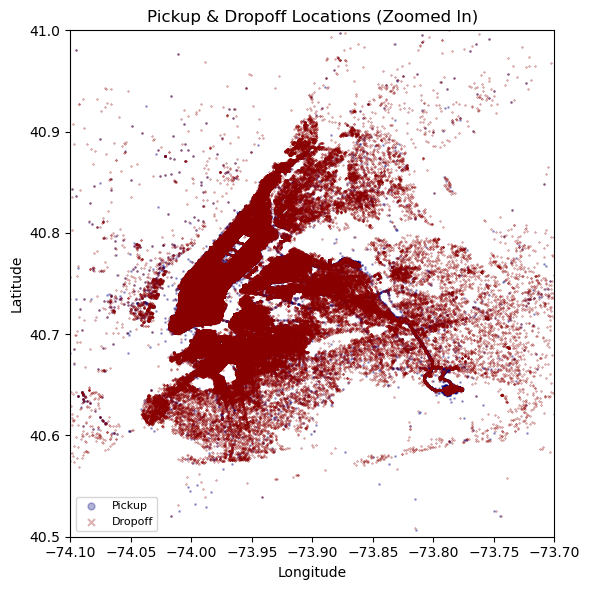

In [364]:
plt.figure(figsize=(6,6))
plt.scatter(coords_pdf["lon"], coords_pdf["lat"],
            s=1, alpha=0.3, label="Pickup", color="navy", marker="o")
plt.scatter(coords_pdf["lon2"], coords_pdf["lat2"],
            s=1, alpha=0.3, label="Dropoff", color="darkred", marker="x")
plt.xlim(-74.1, -73.7) # Giới hạn kinh độ quanh khu vực New York
plt.ylim(40.5, 41.0)  # Giới hạn vĩ độ quanh khu vực New York

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Pickup & Dropoff Locations (Zoomed In)")
plt.legend(markerscale=5, fontsize=8)
plt.tight_layout()
plt.savefig(CHART_DIR + "pickup_dropoff_scatter_zoomed.png", dpi=300, bbox_inches="tight")
plt.show()

Lựa chọn giới hạn kinh độ [-74.1, -73.7] và vĩ độ [40.5, 41.0]

Tiến hành lọc df theo phạm vi không gian trên

In [365]:
MIN_LONGITUDE, MAX_LONGITUDE = -74.1, -73.7
MIN_LATITUDE, MAX_LATITUDE = 40.5, 41.0

print(f"Số dòng ban đầu: {df.count()}")
# Lọc các tọa độ không hợp lệ
df = df.filter(
    (F.col("pickup_longitude").between(MIN_LONGITUDE, MAX_LONGITUDE)) &
    (F.col("pickup_latitude").between(MIN_LATITUDE, MAX_LATITUDE)) &
    (F.col("dropoff_longitude").between(MIN_LONGITUDE, MAX_LONGITUDE)) &
    (F.col("dropoff_latitude").between(MIN_LATITUDE, MAX_LATITUDE))
)

print(f"Số dòng sau khi làm sạch tọa độ: {df.count()}")

Số dòng ban đầu: 1458579
Số dòng sau khi làm sạch tọa độ: 1454392


##### 3.5 Mô tả `trip_duration`

In [366]:
df.select("trip_duration").summary(
    "count", "min", "25%", "50%", "75%", "max", "mean", "stddev"
).show()

+-------+-----------------+
|summary|    trip_duration|
+-------+-----------------+
|  count|          1454392|
|    min|                1|
|    25%|              397|
|    50%|              661|
|    75%|             1071|
|    max|          3526282|
|   mean|955.2720373874444|
| stddev|5238.335980480893|
+-------+-----------------+



- min = 1s (outlier)
- max = 3.5 triệu s = 41 ngày (outlier)
- 25% = 397 s, 1/4 chuyến <=6ph37s
- median = 662s = 11ph
- 75% = = 1075s, 3/4 chuyến <= 18ph, Phần lõi dữ liệu tập trung trước 75%
- mean = 959s > median, dữ liệu lệch phải, dùng log-transform để giảm ảnh hưởng đuôi dài
- stddev = 5 237s, phân tán lớn do outlier
- không mô tả mode vì gần như vô nghĩa với phân phối liên tục lệch phải

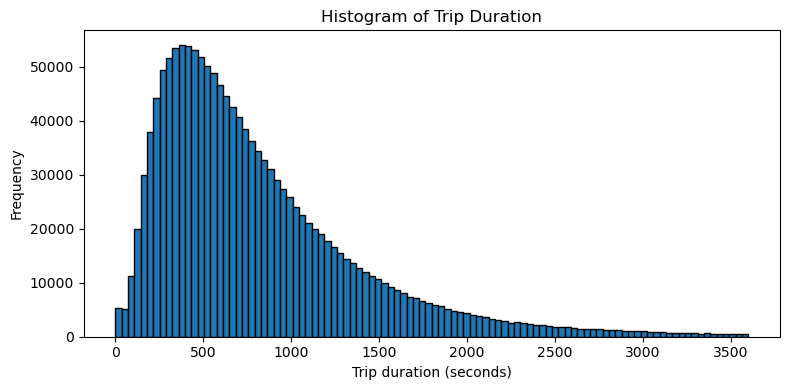

In [367]:
durations = df.select("trip_duration").toPandas()

plt.figure(figsize=(8,4))
# histogram với range=(0, 3600), với range=(0, 7200) có thể thấy đuôi gần như trùng với trục x
plt.hist(durations["trip_duration"], bins=100, range=(0,3600), edgecolor="black")
plt.xlabel("Trip duration (seconds)")
plt.ylabel("Frequency")
plt.title("Histogram of Trip Duration")
plt.tight_layout()
plt.savefig(CHART_DIR + "trip_duration_histogram.png",
            dpi=300, bbox_inches="tight")
plt.show()


Loại bỏ các outlier theo điều kiện (60 <= trip_duration <= 7200)

In [368]:
print(f"Số dòng trước khi loại bỏ outlier: {df.count()}")
# Loại bỏ outlier (60 <= trip_duration <= 7200)
df = df.filter((F.col("trip_duration") >= 60) & (F.col("trip_duration") <= 7200))
print(f"Số dòng sau khi loại bỏ outlier: {df.count()}")

Số dòng trước khi loại bỏ outlier: 1454392
Số dòng sau khi loại bỏ outlier: 1443882


Chuyển đổi dữ liệu

Dùng log(1+x) đem lại độ chính xác cao hơn log(x) với x rất nhỏ ($x << 1$ dẫn tới lỗi làm tròn số khiến hàm log() không xác định)

refer: 
- [Purpose of `numpy.log1p( )`?](https://stackoverflow.com/questions/49538185/purpose-of-numpy-log1p)
- [numpy.log1p — NumPy v2.3 Manual](https://numpy.org/doc/stable/reference/generated/numpy.log1p.html)
- Phù hợp với [công thức RMSLE](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview) mà kaggle đặt ra:

$$
RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(\hat{y}_i + 1) - \log(y_i + 1))^2}
$$

RMSLE giảm ảnh hưởng của outlier, tập trung vào sai số giữa test value và predicted value
trong khi RMSE tập trung đo lường sai số tuyệt đối và độ lớn sai số
$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2}
$$

In [369]:

# log(1 + trip_duration) sau khi loại bỏ outlier
df = df.withColumn("log_duration", F.log1p("trip_duration"))
# preview log_duration
df.select("log_duration").summary(
    "count", "min", "25%", "50%", "75%", "max", "mean", "stddev"
).show()

+-------+------------------+
|summary|      log_duration|
+-------+------------------+
|  count|           1443882|
|    min| 4.110873864173311|
|    25%| 5.993961427306569|
|    50%| 6.499787040655854|
|    75%|6.9782137426306985|
|    max| 8.880724576151456|
|   mean| 6.476925125209057|
| stddev|0.7258492247533144|
+-------+------------------+



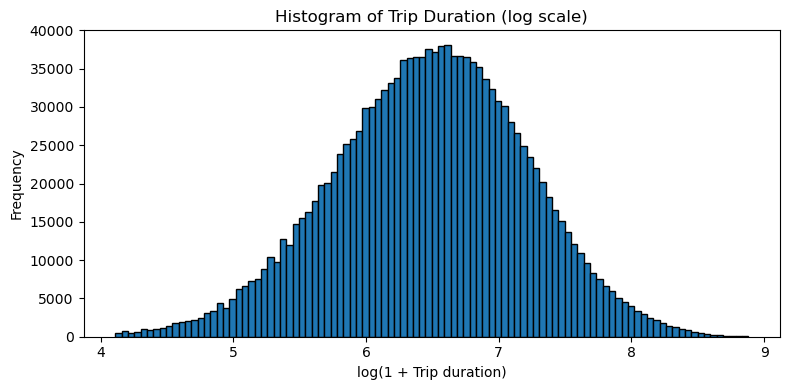

In [370]:
log_pdf = df.select("log_duration").toPandas()

plt.figure(figsize=(8,4))
plt.hist(log_pdf["log_duration"], bins=100, edgecolor="black")
plt.xlabel("log(1 + Trip duration)")
plt.ylabel("Frequency")
plt.title("Histogram of Trip Duration (log scale)")
plt.tight_layout()

plt.savefig(CHART_DIR + "trip_duration_hist_log.png",
            dpi=300, bbox_inches="tight", facecolor='white')
plt.show()

Phân phối đã trở nên đối xứng, có dạng gần giống hình chuông (phân phối chuẩn) phù hợp với mô hình hoá, đặc biệt là Linear Regression.

Giá trị tập trung từ 6-7

#### 3.5. Tính khoảng cách Haversine và loại bỏ outlier tốc độ

Tính toán [khoảng cách Haversine](https://www.movable-type.co.uk/scripts/latlong.html) (ưu tiên atan2 về độ ổn định theo nguồn tham khảo)
$$ 
d_{Haversine} = 2R \cdot \operatorname{atan2} \left( \sqrt{\sin^2\left(\frac{\Delta \phi}{2}\right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2\left(\frac{\Delta \lambda}{2}\right)} \right)
$$

Trong đó:
- R là bán kính trái đất (6371 km)
- $\phi_1$, $\phi_2$ là vĩ độ (latitude) của điểm pickup và dropoff (radians)
- $\lambda_1$, $\lambda_2$ là kinh độ (longitude) của điểm pickup và dropoff (radians)
- $\Delta \phi = \phi_2 - \phi_1$ là hiệu vĩ độ
- $\Delta \lambda = \lambda_2 - \lambda_1$ là hiệu kinh độ

Tính tốc độ trung bình toàn tuyến (km/h)

Lọc bỏ những outlier theo điều kiện (2 <= avg_speed_kmh <= 120) và (distance_km > 0)

In [371]:
from math import radians, sin, cos, sqrt, atan2
# 1.1 UDF tính Haversine
@F.udf("double")
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Thêm cột distance_km vào DataFrame
df = df.withColumn("distance_km", haversine_km(
        F.col("pickup_latitude"),  F.col("pickup_longitude"),
        F.col("dropoff_latitude"), F.col("dropoff_longitude")))

# Thêm cột avg_speed_kmh (km/h)
df = (df.withColumn("avg_speed_kmh", F.col("distance_km") / (F.col("trip_duration")/3600))
)

print("Số bản ghi trước lọc:", df.count())
#  Lọc bỏ các chuyến đi có distance_km = 0 hoặc avg_speed_kmh nằm ngoài ngưỡng thực tế (2-120 km/h).
df = df.filter(
    (F.col("distance_km") > 0) &
    (F.col("avg_speed_kmh").between(2, 120))
)
print("Số bản ghi sau lọc:", df.count())


Số bản ghi trước lọc: 1443882
Số bản ghi sau lọc: 1432677


#### 3.5 Trích xuất đặc trưng từ `pickup_datetime`

In [372]:
# Trích xuất cột thời gian từ pickup_datetime
df = df.withColumn("pickup_hour",    F.hour("pickup_datetime")) \
       .withColumn("pickup_weekday", F.dayofweek("pickup_datetime")) \
       .withColumn("pickup_month",   F.month("pickup_datetime"))

# Thống kê số lượng chuyến taxi theo giờ, ngày trong tuần và tháng
hour_counts    = df.groupBy("pickup_hour").count().orderBy("pickup_hour")
weekday_counts = df.groupBy("pickup_weekday").count().orderBy("pickup_weekday")
month_counts   = df.groupBy("pickup_month").count().orderBy("pickup_month")

# Hiển thị thống kê
hour_counts.show()
weekday_counts.show()
month_counts.show()

+-----------+-----+
|pickup_hour|count|
+-----------+-----+
|          0|52305|
|          1|37838|
|          2|27385|
|          3|20403|
|          4|15251|
|          5|14487|
|          6|32599|
|          7|54537|
|          8|65922|
|          9|66568|
|         10|64352|
|         11|67215|
|         12|70512|
|         13|70077|
|         14|72699|
|         15|70310|
|         16|63008|
|         17|75065|
|         18|89198|
|         19|89017|
+-----------+-----+
only showing top 20 rows

+--------------+------+
|pickup_weekday| count|
+--------------+------+
|             1|191639|
|             2|184194|
|             3|199252|
|             4|206520|
|             5|214594|
|             6|219468|
|             7|217010|
+--------------+------+

+------------+------+
|pickup_month| count|
+------------+------+
|           1|225673|
|           2|234246|
|           3|251896|
|           4|247125|
|           5|243862|
|           6|229875|
+------------+------+



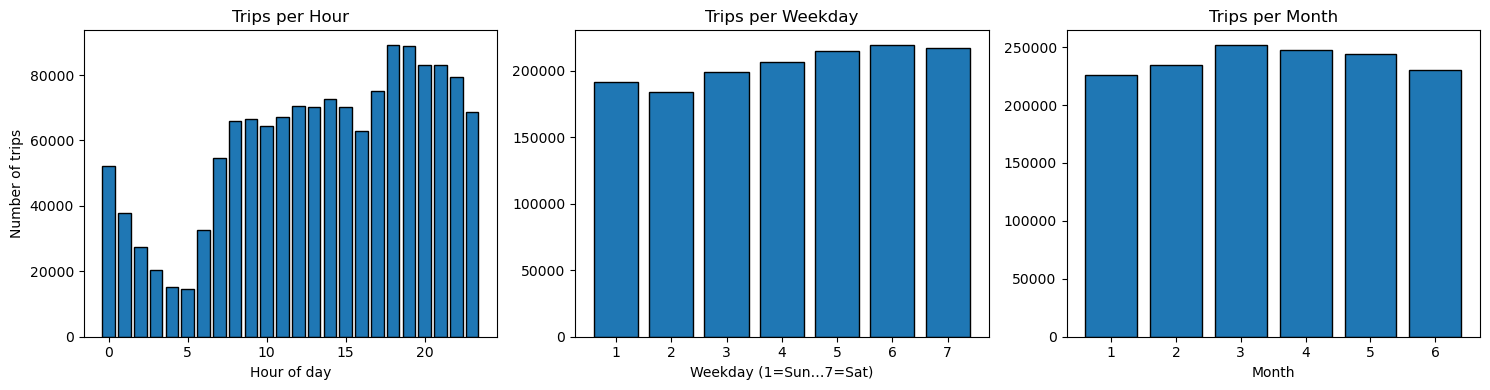

In [373]:

pdf_hour    = hour_counts.toPandas()
pdf_weekday = weekday_counts.toPandas()
pdf_month   = month_counts.toPandas()

fig, axes = plt.subplots(1, 3, figsize=(15,4))

# Trips per hour
axes[0].bar(pdf_hour["pickup_hour"], pdf_hour["count"], edgecolor="black")
axes[0].set_xlabel("Hour of day")
axes[0].set_ylabel("Number of trips")
axes[0].set_title("Trips per Hour")

# Trips per weekday (1=Sun…7=Sat)
axes[1].bar(pdf_weekday["pickup_weekday"], pdf_weekday["count"], edgecolor="black")
axes[1].set_xlabel("Weekday (1=Sun…7=Sat)")
axes[1].set_title("Trips per Weekday")

# Trips per month
axes[2].bar(pdf_month["pickup_month"], pdf_month["count"], edgecolor="black")
axes[2].set_xlabel("Month")
axes[2].set_title("Trips per Month")

plt.tight_layout()
plt.savefig(CHART_DIR + "time_feature_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

**Đánh giá Trips per hour**

Giờ thấp điểm: 3-5 giờ sáng, bắt đầu từ 0h

Giờ cao điểm: có 2 đỉnh rõ rệt
- đỉnh cao nhất là khoảng 18-19h, tương ứng giờ tan ca và các hoạt động tối
- đỉnh thấp hơn là khoảng 

**Đánh giá Trips per Weekday**

Tăng dần về cuối tuần, đạt đỉnh ở thứ 6 (ngày đầu tiên của nghỉ cuối tuần)

**Đánh giá Trips per Month**

Đỉnh điểm ở tháng 3, là thời điểm thời tiết dễ chịu sau mùa đông phù hợp với các sự kiện ngoài trời

### 4. Phân tích mối tương quan các biến

#### 4.1 Xây dựng biểu đồ tương quan


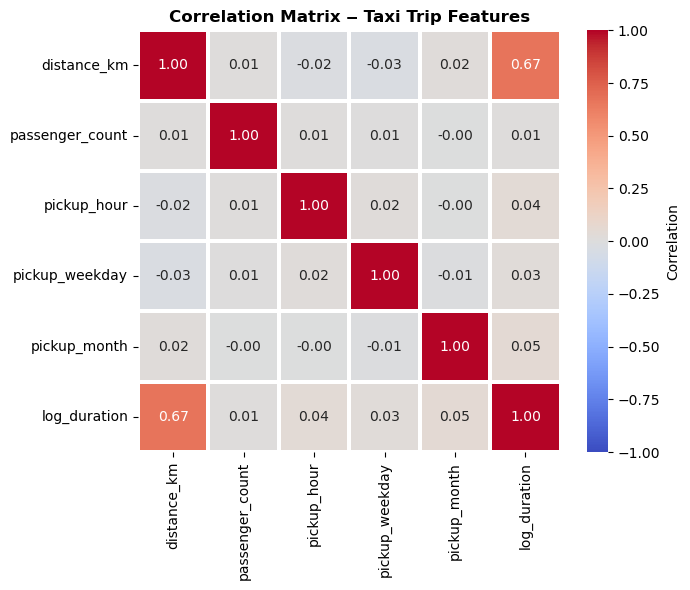

=== CÁC TƯƠNG QUAN QUAN TRỌNG ===
distance_km ↔ log_duration: 0.670


In [374]:
# Correlation matrix
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd

cols = ["distance_km","passenger_count",
        "pickup_hour","pickup_weekday","pickup_month",
        "log_duration"]

vec = VectorAssembler(inputCols=cols, outputCol="vec").transform(df)
corr = Correlation.corr(vec, "vec", "pearson").head()[0].toArray()

# Tạo DataFrame pandas từ ma trận correlation
corr_pd = pd.DataFrame(corr, index=cols, columns=cols)

plt.figure(figsize=(7,6))
sns.heatmap(
    corr, annot=True, fmt=".2f",
    xticklabels=cols, yticklabels=cols,
    cmap="coolwarm", vmin=-1, vmax=1,
    linewidths=1.5, linecolor="white",
    cbar_kws={"label": "Correlation"}
)
plt.title("Correlation Matrix ‒ Taxi Trip Features", fontweight="bold")
plt.tight_layout()
plt.savefig(f"{CHART_DIR}/corr_heatmap_colored.png", dpi=300, facecolor='white')
plt.show()

# 5) In ra các correlation quan trọng (> 0.3 hoặc < -0.3)
print("=== CÁC TƯƠNG QUAN QUAN TRỌNG ===")
for i in range(len(corr_pd.columns)):
    for j in range(i+1, len(corr_pd.columns)):
        corr_val = corr_pd.iloc[i, j]
        if abs(corr_val) > 0.3:
            print(f"{corr_pd.columns[i]} ↔ {corr_pd.columns[j]}: {corr_val:.3f}")

#### Nhận xét – Ma trận Tương quan  
* **`distance_km` ↔ `log_duration` = 0 .67** ⇒ đặc trưng dự báo mạnh nhất.  
* Các biến thời gian (`pickup_hour`, `pickup_weekday`, `pickup_month`) & `passenger_count` đều |r| < 0 .05 ⇒ quan hệ tuyến tính yếu.  
* Không có cặp > 0 .9 ⇒ **không đa cộng tuyến**.  
**Quyết định**  
* Giữ `distance_km`, `pickup_hour` (đã có ý nghĩa phi tuyến khi quy thành `is_peak`).  


#### 4.2 Biểu đồ Scatter – kiểm tra tuyến tính Distance - Trip Duration  

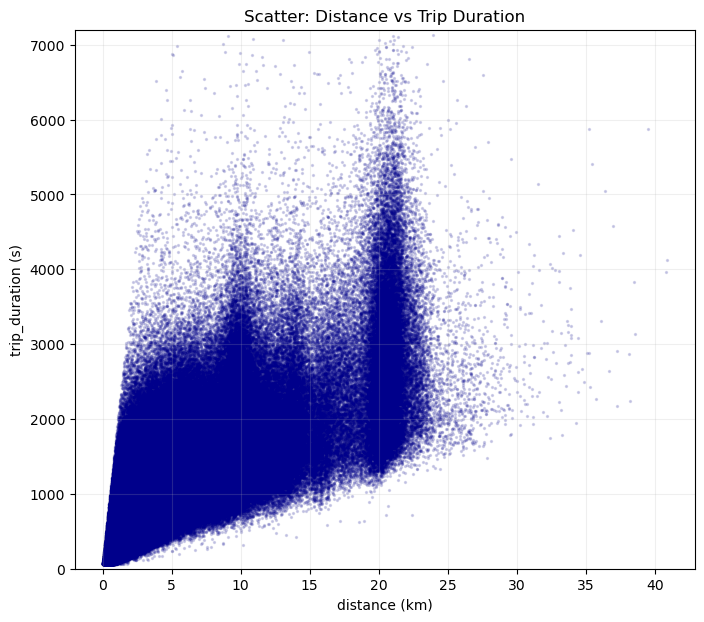

In [375]:
# Scatter (distance vs duration)
pts = df.select("distance_km", "trip_duration").collect()
x = [r["distance_km"] for r in pts]
y = [r["trip_duration"] for r in pts]

plt.figure(figsize=(8,7))
plt.scatter(x, y, s=2, alpha=0.15, color="darkblue")
plt.xlabel("distance (km)")
plt.ylabel("trip_duration (s)")
plt.title("Scatter: Distance vs Trip Duration")
plt.ylim(0, 7200)
plt.grid(alpha=0.2)
plt.savefig(f"{CHART_DIR}/scatter_distance_duration.png", dpi=150)
plt.show()


#### Nhận xét – Scatter: Distance vs Trip Duration  
* Đám mây tam giác chỉ ra quan hệ gần tuyến tính trong 0–15 km.  
* Cột dày tại 18–22 km : chuyến **Manhattan** – độ tản lớn do kẹt cao tốc.  
**Quyết định**  
* Thêm cột nhị phân **`airport_trip`** (18 ≤ distance ≤ 23 km).  
* Linear Regression phù hợp cho dải 0–20 km; biến tương tác `distance_km × is_peak` giúp chỉnh dốc cao điểm.


In [376]:
stats_df = (df.groupBy("pickup_hour")
              .agg(
                  F.count("*").alias("count"),
                  F.min("trip_duration").alias("min"),
                  F.expr("percentile_approx(trip_duration, 0.25)").alias("Q1"),
                  F.expr("percentile_approx(trip_duration, 0.50)").alias("median"),
                  F.expr("percentile_approx(trip_duration, 0.75)").alias("Q3"),
                  F.max("trip_duration").alias("max"),
                  F.mean("trip_duration").alias("mean"),
                  F.stddev("trip_duration").alias("stddev")
              )
              .withColumn("IQR", F.col("Q3") - F.col("Q1"))
              .orderBy("pickup_hour"))

# Hiển thị dưới dạng bảng Spark
stats_df.show(24, truncate=False)

+-----------+-----+---+---+------+----+----+-----------------+------------------+---+
|pickup_hour|count|min|Q1 |median|Q3  |max |mean             |stddev            |IQR|
+-----------+-----+---+---+------+----+----+-----------------+------------------+---+
|0          |52305|60 |395|648   |1038|6978|783.6399005831182|534.765767148257  |643|
|1          |37838|60 |376|615   |974 |6857|739.2652095776732|511.5546589921837 |598|
|2          |27385|60 |359|593   |940 |5610|703.68625159759  |464.32715662541943|581|
|3          |20403|61 |357|595   |952 |6841|705.7997353330393|469.2969112498658 |595|
|4          |15251|60 |349|613   |1020|5923|735.5449478722707|501.4579299117321 |671|
|5          |14487|60 |293|517   |978 |6420|707.3999447780769|564.5261167429536 |685|
|6          |32599|60 |294|474   |798 |6928|670.452345163962 |635.0303086024146 |504|
|7          |54537|60 |358|574   |911 |7098|755.7499862478684|680.3392166577137 |553|
|8          |65922|60 |397|661   |1063|6914|833.010391

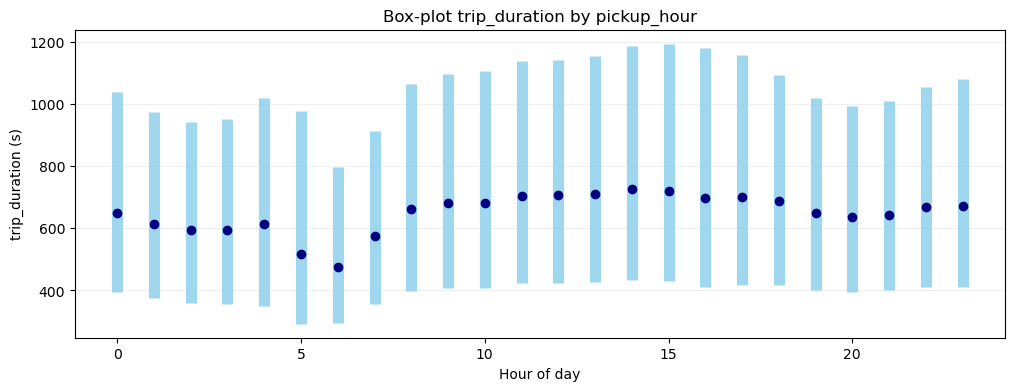

In [377]:
stats = (df.groupBy("pickup_hour")
           .agg(F.expr("percentile_approx(trip_duration,0.25) q1"),
                F.expr("percentile_approx(trip_duration,0.50) median"),
                F.expr("percentile_approx(trip_duration,0.75) q3"))
           .orderBy("pickup_hour")
           .collect())
hr   = [r["pickup_hour"] for r in stats]
q1   = [r["q1"] for r in stats]
med  = [r["median"] for r in stats]
q3   = [r["q3"] for r in stats]

plt.figure(figsize=(12,4))
plt.vlines(hr, q1, q3, lw=8, color="skyblue", alpha=0.8)
plt.scatter(hr, med, color="navy", zorder=3)
plt.xlabel("Hour of day")
plt.ylabel("trip_duration (s)")
plt.title("Box-plot trip_duration by pickup_hour")
plt.grid(alpha=0.2, axis="y")
plt.savefig(f"{CHART_DIR}/boxplot_duration_by_hour.png", dpi=150)
plt.show()


#### Nhận xét – Box-plot trip_duration theo Giờ (NY time)  
* Giờ vắng 4–6 h: median ≈ 520 s, IQR hẹp.  
* **Cao điểm** 7–9 h & 16–19 h: median ↑ ~100 s; IQR ↑ 150–300 s.  
* Đỉnh phụ 14–16 h nhưng không phải rush-hour kinh điển.  
**Quyết định**  
* Tạo cờ **`is_peak`** = 1 cho giờ {7, 8, 9, 16, 17, 18, 19}.  


In [378]:
peak_hours = [7, 8, 9, 16, 17, 18, 19]

df = df.withColumn("is_peak", (F.col("pickup_hour").isin(peak_hours)).cast("int"))

df.groupBy("is_peak").count().show()

# Airport trip flag (18-23 km)
df = df.withColumn(
    "airport_trip",
    F.col("distance_km").between(18, 23).cast("int")
)

# Interaction: distance × is_peak
df = df.withColumn(
    "distance_peak",
    F.col("distance_km") * F.col("is_peak")
)


+-------+------+
|is_peak| count|
+-------+------+
|      1|503315|
|      0|929362|
+-------+------+



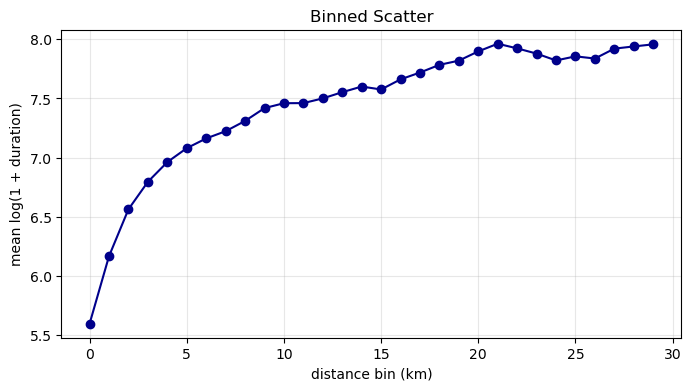

In [379]:
BIN_KM, MAX_KM = 1, 30
rows = (df.filter(F.col("distance_km") <= MAX_KM)
          .withColumn("bin_km", F.floor(F.col("distance_km")/BIN_KM)*BIN_KM)
          .groupBy("bin_km")
          .agg(F.mean("log_duration").alias("mean_log"))
          .orderBy("bin_km")
          .collect())
bins  = [r["bin_km"]   for r in rows]
means = [r["mean_log"] for r in rows]

plt.figure(figsize=(8,4))
plt.plot(bins, means, marker="o", color="darkblue")
plt.xlabel("distance bin (km)")
plt.ylabel("mean log(1 + duration)")
plt.title("Binned Scatter")
plt.grid(True, alpha=0.3)
plt.savefig(f"{CHART_DIR}/binned_scatter_logdur_full.png", dpi=300)
plt.show()


#### Nhận xét – Binned Scatter log(1+duration) theo distance_km  
* 5–18 km: gần tuyến tính tuyệt đối trên thang log.  
* < 4 km và > 20 km hơi cong do dừng đèn/đường cao tốc.  

In [380]:
import shutil
from glob import glob

print("=== LƯU CLEANED DATA ===")
print(f"Số dòng cuối cùng: {df.count()}")
print(f"Số cột           : {len(df.columns)}")
print("Các cột hiện có  :")
for c in df.columns:
    print(f"  - {c}")

df.show(5, truncate=False)

# 1) Ghi ra thư mục tạm
tmp_path = "/home/jovyan/work/data/processed/cleaned_data_tmp"
if os.path.exists(tmp_path):
    shutil.rmtree(tmp_path)

df.coalesce(1) \
  .write \
  .mode("overwrite") \
  .option("header", True) \
  .csv(tmp_path)

# 2) Tìm file part-*.csv và di chuyển đến file duy nhất
part_file = glob(os.path.join(tmp_path, "part-*.csv"))[0]
final_path = "/home/jovyan/work/data/processed/cleaned_data.csv"
os.makedirs(os.path.dirname(final_path), exist_ok=True)
if os.path.exists(final_path):
    os.remove(final_path)
shutil.move(part_file, final_path)

# 3) Xóa thư mục tạm
shutil.rmtree(tmp_path)

print(f"► Đã lưu cleaned data thành 1 file tại: {final_path}")

print("\n=== TÓM TẮT QUÁ TRÌNH CLEANING ===")
print("1. Loại bỏ passenger_count outliers: {0, 7, 8, 9}")
print("2. Loại bỏ trip_duration outliers: < 60s hoặc > 7200s (2h)")
print("3. Loại bỏ tọa độ không hợp lệ ngoài phạm vi (-74.1, -73.7) x (40.5, 41.0)")
print("4. Tính toán distance_km và avg_speed_kmh, loại bỏ các bản ghi có avg_speed_kmh < 2 hoặc > 120 km/h")
print("5. Thêm các cột thời gian: pickup_hour, pickup_weekday, pickup_month")
print("6. Thêm cột is_peak (1 nếu giờ cao điểm, 0 nếu không)")
print("7. Thêm cột airport_trip (1 nếu khoảng cách 18-23 km, 0 nếu không)")
print("8. Thêm cột distance_peak (distance_km × is_peak)")
print("9. Thêm cột log_duration (log(1 + trip_duration))")
print("10. Lưu dữ liệu đã làm sạch vào file CSV duy nhất")


=== LƯU CLEANED DATA ===
Số dòng cuối cùng: 1432677
Số cột           : 21
Các cột hiện có  :
  - id
  - vendor_id
  - pickup_datetime
  - dropoff_datetime
  - passenger_count
  - pickup_longitude
  - pickup_latitude
  - dropoff_longitude
  - dropoff_latitude
  - store_and_fwd_flag
  - trip_duration
  - store_and_fwd_flag_num
  - log_duration
  - distance_km
  - avg_speed_kmh
  - pickup_hour
  - pickup_weekday
  - pickup_month
  - is_peak
  - airport_trip
  - distance_peak
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+----------------------+------------------+------------------+------------------+-----------+--------------+------------+-------+------------+------------------+
|id       |vendor_id|pickup_datetime    |dropoff_datetime   |passenger_count|pickup_longitude  |pickup_latitude   |dropoff_longitude |dropoff_latitude  |store_and_fwd_flag|trip